## import 需要的库
在执行此note前，先启动环境, 在windows命令提示符下执行:
```
conda env list
activate dlnd-tf-lab
```

In [4]:
import os
import random
import shutil
import fnmatch
import math
import pickle
from keras.layers import *
from keras import optimizers
from keras import losses
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

import utils, models
import importlib
importlib.reload(utils)
importlib.reload(models)

<module 'models' from 'E:\\My_study_place\\python\\jupyter\\kaggle\\Human Protein Atlas Image Classification\\models.py'>

## Prepare the training data for training
- split the data
- build model and do training

In [4]:
# Split the data
def splitCategoryTrainValid(categoryName, categorizedDir="./categorizedTrain", trainDir="./train",
                      testPercent=0.3, randomSeed=None, createLink=False, filterPattern="*_green.png"):
    """ 
    # Description: split the data in categorizedDir to train and valid based on testPercent
    # Arguments
        categoryName: name of category to be splited
        categorizedDir: the directory in which data that already been categorized have been saved
        trainDir: the directory that will be used to save the training data, there will be two subdir names 'train', 'valid' in it
        testPercent: the percentage of data that will be used to do validation
        randomSeed: random seed for the split
        createLink: whether to create a link to the target file or just copy it.
        filterPattern: pattern to filter the images
    # Returns
        trainSize: the # of samples that splited for training
        validSize: the # of samples that splited for validation
    # Raises
        None
    
    """
    if testPercent <=0 or testPercent >=1:
        raise Exception("\n testPercent must be in (0,1)")
        
    sourceDir = os.path.join(categorizedDir, categoryName)
    destTrainDir = os.path.join(trainDir , "train", categoryName)
    destValidDir = os.path.join(trainDir , "valid", categoryName)
    
    # fileNames = os.listdir(sourceDir)
    fileNames = fnmatch.filter(os.listdir(sourceDir),filterPattern)
    totalSize = len(fileNames)
    testSize = int(totalSize * testPercent)
    trainSize = totalSize - testSize
    
    if not randomSeed is None:
        random.seed(randomSeed)
    random.shuffle(fileNames)
    utils.rebuildDir(destTrainDir)
    utils.rebuildDir(destValidDir)
    for i in range(0, totalSize):
        if i < testSize:
            destDir = destValidDir
        else:
            destDir = destTrainDir
        
        if createLink == True:
                os.symlink(os.path.join(sourceDir, fileNames[i]), os.path.join(destDir, fileNames[i]))
        else:
                shutil.copy(os.path.join(sourceDir, fileNames[i]), destDir)
                
    return trainSize, testSize

def splitAllTrainValid(categorizedDir="./categorizedTrain", trainDir="./train",
                      testPercent=0.3, randomSeed=None, createLink=False):
    """ 
    # Description: split the data in categorizedDir to train and valid based on testPercent
    # Arguments
        categorizedDir: the directory in which data that already been categorized have been saved
        trainDir: the directory that will be used to save the training data, there will be two subdir names 'train', 'valid' in it
        testPercent: the percentage of data that will be used to do validation
        randomSeed: random seed for the split
        createLink: whether to create a link to the target file or just copy it.
    # Returns
        None
    # Raises
        None
    """
    categories = os.listdir(categorizedDir)
    for categoryName in categories:
        trainSize, validSize = splitCategoryTrainValid(categoryName, categorizedDir, trainDir, testPercent, randomSeed, createLink)
        print("category: ", categoryName, ",trainSize:", trainSize, ",validSize:", validSize)
    
#test
splitCategoryTrainValid("Nucleoli")

splitAllTrainValid()

category:  Actin filaments ,trainSize: 9 ,validSize: 3
category:  Aggresome ,trainSize: 2 ,validSize: 0
category:  Cell junctions ,trainSize: 7 ,validSize: 2
category:  Centrosome ,trainSize: 15 ,validSize: 6
category:  Cytokinetic bridge ,trainSize: 10 ,validSize: 3
category:  Cytoplasmic bodies ,trainSize: 7 ,validSize: 2
category:  Cytosol ,trainSize: 120 ,validSize: 51
category:  Endoplasmic reticulum ,trainSize: 12 ,validSize: 4
category:  Endosomes ,trainSize: 2 ,validSize: 0
category:  Focal adhesion sites ,trainSize: 5 ,validSize: 2
category:  Golgi apparatus ,trainSize: 35 ,validSize: 14
category:  Intermediate filaments ,trainSize: 14 ,validSize: 6
category:  Lipid droplets ,trainSize: 3 ,validSize: 1
category:  Lysosomes ,trainSize: 2 ,validSize: 0
category:  Microtubule ends ,trainSize: 0 ,validSize: 0
category:  Microtubule organizing center ,trainSize: 15 ,validSize: 6
category:  Microtubules ,trainSize: 14 ,validSize: 5
category:  Mitochondria ,trainSize: 35 ,validSize: 

In [2]:
def getDataSize(dir, filterPattern):
    subDirs = os.listdir(dir)
    sum = 0
    for subdir in subDirs:
        sum += len(fnmatch.filter(os.listdir(os.path.join(dir, subdir)),filterPattern))
    return sum

def doTraining(model, modelName, epoch, imageSize, numPerbatch, 
               trainDir,validDir, filterPattern):
    """
    # Description: 
    # Arguments
        
    # Returns
        None
    # Raises
        None
    """
    trainSize = getDataSize(trainDir, filterPattern)
    validSize = getDataSize(validDir, filterPattern)
    
    trainDataGen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format='channels_last') 
    validDataGen = ImageDataGenerator(rescale=1./255,
                           data_format='channels_last')
   
    trainGenerator = trainDataGen.flow_from_directory(
       trainDir,
       target_size=imageSize,
       batch_size = numPerbatch,
       shuffle = True,
       class_mode='binary')
    validGenerator = validDataGen.flow_from_directory( 
       validDir,
       target_size=imageSize,
       batch_size = numPerbatch,
       shuffle = True,
       class_mode='binary')

    
    '''
    The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number     of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. 
    Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed.
    '''
    # logLocation = "./" + modelName
    # tensorBoard = callbacks.TensorBoard(log_dir=logLocation)
    # earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)  
    filePath = "./" + modelName + "_top.h5"
    checkPoint = callbacks.ModelCheckpoint(filePath, "val_loss", verbose=1, save_best_only=True)
    # callBacks = [tensorBoard, earlyStopping, checkPoint]
    callBacks = [checkPoint]
    
    
    history = model.fit_generator(trainGenerator,
                steps_per_epoch = math.ceil(trainSize / numPerbatch), 
                epochs = epoch,
                validation_data=validGenerator,
                validation_steps = math.ceil(validSize / numPerbatch),
                callbacks=callBacks)
    
    return history

Found 433 images belonging to 28 classes.
Found 275 images belonging to 28 classes.
Epoch 1/1
14/14 [==============================] - 609s - loss: 3.3040 - acc: 0.1052 - val_loss: 3.2796 - val_acc: 0.1055
dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


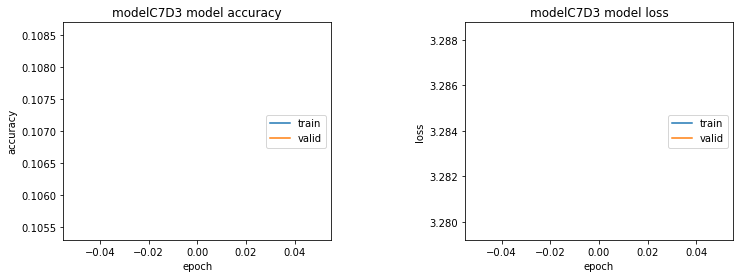

In [5]:
imageShape=(512,512,3)
labelSize = 28
modelName = "modelC7D3"
perbatch = 32
pochNum = 1
# TODO: replace all the trainDataDir and above variables
trainDataDir = "./train/train"
validDataDir = "./train/valid"

modelC7D3 = models.modelC7D3(imageShape, labelSize)
# modelC7D3.summary()
adam = optimizers.Adam(lr=0.0001)
rmsp = optimizers.RMSprop(lr=0.0001)
modelC7D3.compile(optimizer=adam, loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
utils.visualizeModel(modelC7D3, modelName)
modelHistory = doTraining(modelC7D3, modelName=modelName, epoch=pochNum,
                          imageSize = (imageShape[:-1]), numPerbatch=perbatch,
                          trainDir=trainDataDir, validDir=validDataDir,filterPattern="*_green.png")
utils.visualizeHistory(modelHistory, modelName)
with open(modelName+'.pickle', 'wb') as f:
    pickle.dump(modelHistory.history, f)
utils.saveModel(modelC7D3, modelName)